In [29]:
# Import libraries
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [30]:
# Import data
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

print(train.shape, test.shape)

(42000, 785) (28000, 784)


In [31]:

# Split training data into training and validation sets
train, val = train_test_split(train, test_size=0.2, random_state=42)
print(train.shape, val.shape)

(33600, 785) (8400, 785)


In [32]:
# Separate features and labels
train_labels = train['label']
train_features = train.drop(['label'], axis=1)
val_labels = val['label']
val_features = val.drop(['label'], axis=1)

print(train_features.shape, val_features.shape, test.shape)

(33600, 784) (8400, 784) (28000, 784)


In [33]:

# Reshape features
train_features = train_features.values.reshape(-1, 28, 28, 1)
val_features = val_features.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

print(train_features.shape, val_features.shape, test.shape)

(33600, 28, 28, 1) (8400, 28, 28, 1) (28000, 28, 28, 1)


In [34]:
print(train_labels.shape, val_labels.shape)
# Convert labels to categorical
train_labels = to_categorical(train_labels)
val_labels = to_categorical(val_labels)

print(train_labels.shape, val_labels.shape)

(33600,) (8400,)
(33600, 10) (8400, 10)


In [35]:
# Normalize features
train_features = train_features / 255
val_features = val_features / 255

In [36]:
# Create model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same', activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=10, activation='softmax'))

In [37]:
# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
# Set early stopping monitor so the model stops training when it won't improve anymore
early_stopping_monitor = EarlyStopping(patience=3)


In [39]:
# Train model
start_time = time.time()
model.fit(train_features, train_labels, epochs=30, validation_data=(val_features, val_labels), callbacks=[early_stopping_monitor])
end_time = time.time()
print("Training time: {}".format(end_time - start_time))

Epoch 1/30
1050/1050 [==============================] - 151s 142ms/step - loss: 0.2250 - accuracy: 0.9283 - val_loss: 0.0677 - val_accuracy: 0.9796
Epoch 2/30
1050/1050 [==============================] - 150s 142ms/step - loss: 0.0779 - accuracy: 0.9768 - val_loss: 0.0383 - val_accuracy: 0.9877
Epoch 3/30
1050/1050 [==============================] - 150s 143ms/step - loss: 0.0610 - accuracy: 0.9821 - val_loss: 0.0441 - val_accuracy: 0.9871
Epoch 4/30
1050/1050 [==============================] - 148s 141ms/step - loss: 0.0496 - accuracy: 0.9852 - val_loss: 0.0318 - val_accuracy: 0.9900
Epoch 5/30
1050/1050 [==============================] - 149s 142ms/step - loss: 0.0424 - accuracy: 0.9869 - val_loss: 0.0303 - val_accuracy: 0.9917
Epoch 6/30
1050/1050 [==============================] - 148s 141ms/step - loss: 0.0399 - accuracy: 0.9881 - val_loss: 0.0332 - val_accuracy: 0.9900
Epoch 7/30
1050/1050 [==============================] - 147s 140ms/step - loss: 0.0350 - accuracy: 0.9897 - val_

In [40]:
# Save model
model.save('digit_recognizer_model.h5')

In [41]:
# Make predictions
predictions = model.predict(test)
predictions = np.argmax(predictions, axis=1)

875/875 [==============================] - 25s 29ms/step


In [45]:
# Create submission file
submission = pd.DataFrame({'ImageId': range(1, len(predictions) + 1), 'Label': predictions})
submission.to_csv('submission.csv', index=False)


In [43]:
# Create confusion matrix
val_predictions = model.predict(val_features)
val_predictions = np.argmax(val_predictions, axis=1)
val_labels = np.argmax(val_labels, axis=1)
confusion_matrix = confusion_matrix(val_labels, val_predictions)
print(confusion_matrix)

263/263 [==============================] - 8s 30ms/step
[[808   0   1   0   0   2   3   0   2   0]
 [  0 903   2   0   0   1   1   1   1   0]
 [  1   0 841   2   0   0   0   1   1   0]
 [  0   0   0 933   0   1   0   0   3   0]
 [  1   0   0   0 830   0   4   0   0   4]
 [  0   0   0   1   0 697   1   0   2   1]
 [  0   1   0   0   0   1 782   0   1   0]
 [  0   1   1   1   1   0   0 885   0   4]
 [  0   0   0   0   0   2   0   0 831   2]
 [  1   0   0   0   2   1   0   1   3 830]]


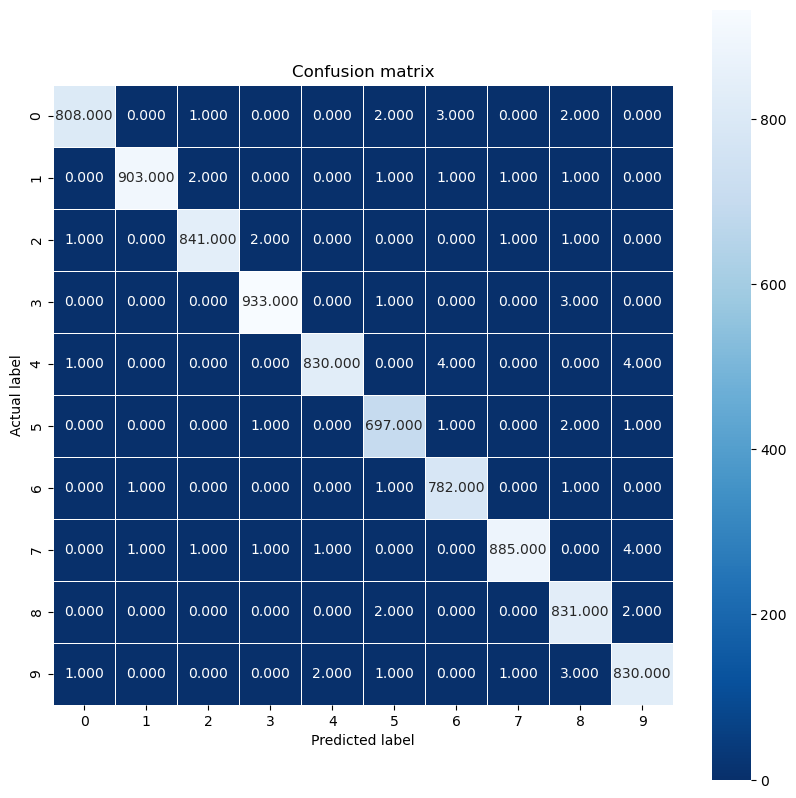

In [46]:
# Plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, fmt='.3f', linewidths=.5, square=True, cmap='Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix')
plt.show()
plt.savefig('confusion_matrix.png')
plt.close()
